In [47]:
from dotenv import load_dotenv
load_dotenv()

True

In [48]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("google_genai:gemini-2.0-flash")

In [49]:
# State define
from typing import TypedDict, Annotated
from langgraph.graph import add_messages

class ChatState(TypedDict):
    messages: Annotated[list, add_messages]

In [50]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [51]:
@tool
def get_price(symbol: str) -> float:
    # required docstring -> needed for langchain to identify the tool
    """Return the stock price for the given symbol."""
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_price]
llm_with_tools = llm.bind_tools(tools)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [52]:
tools

[StructuredTool(name='get_price', description='Return the stock price for the given symbol.', args_schema=<class 'langchain_core.utils.pydantic.get_price'>, func=<function get_price at 0x00000248288B3740>)]

In [53]:
def chatbot(state: ChatState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [54]:
# graph with tool
from langgraph.graph import StateGraph, START, END
builder = StateGraph(ChatState)
builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
# from tool call loop back to the llm to generate proper ans
builder.add_edge("tools", "chatbot")

graph = builder.compile()

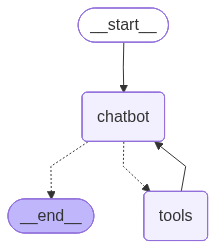

In [55]:
# Visualising the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
res = graph.invoke({'messages': ['I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?']})
res

{'messages': [HumanMessage(content='I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?', additional_kwargs={}, response_metadata={}, id='f0fdcd37-52eb-4cd6-aa3a-da9ebd2955c2'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_price', 'arguments': '{"symbol": "MSFT"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--df797d32-06ce-4817-882f-ed4742acb790-0', tool_calls=[{'name': 'get_price', 'args': {'symbol': 'AMZN'}, 'id': '4ffe7285-5676-4bb9-995f-d34bc0d1be92', 'type': 'tool_call'}, {'name': 'get_price', 'args': {'symbol': 'MSFT'}, 'id': '67673969-6658-4a8c-96a4-4c03d3f7515a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 53, 'output_tokens': 12, 'total_tokens': 65}),
  ToolMessage(content='150.0', name='get_price', id='62e6a243-8d79-4b86-9bd9-2dc4f63aa079', tool_call_id='4ffe7285-5676-4bb9-995f-d34bc0d1be92'),
  ToolMes

In [57]:
res['messages'][-1].content 

'AMZN is trading at $150 and MSFT is trading at $150. To buy 20 AMZN stocks and 15 MSFT stocks, the total cost would be (20 * 150) + (15 * 150) = $5,250.\n'

## ***Memory Utilisation***

In [58]:
from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()

In [59]:
graph2 = builder.compile(checkpointer=checkpointer)

In [60]:
config1 = {"configurable": {"thread_id": "1"}} # suppose it's the chats of user 1
res = graph2.invoke({'messages': ['I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?']}, config=config1)
res['messages'][-1].content 

'AMZN is trading at $150 and MSFT is trading at $150.\n\nTo buy 20 AMZN stocks, it would cost 20 * $150 = $3000.\nTo buy 15 MSFT stocks, it would cost 15 * $150 = $2250.\n\nTherefore, the total cost would be $3000 + $2250 = $5250.\n'

In [61]:
config2 = {"configurable": {"thread_id": "2"}} # suppose it's the chats of user 2
res = graph2.invoke({'messages': ['I want to buy 20 AMZN stocks using current price. Then 15 AAPL. What will be the total cost?']}, config=config2)
res['messages'][-1].content 

'AMZN costs $150 and AAPL costs $150.\n20 AMZN stocks will cost $3000, and 15 AAPL stocks will cost $2250.\nThe total cost will be $5250.'